# Power and N_exc dependence

In [2]:
import qucat as qc
import qutip as qt
import scipy as sc
import matplotlib.pyplot as plt
import numpy as np
import data_gen_time as dt

In [38]:
def DB_basis(a_ops, args, RWA=True):
    N_exc = a_ops[0].dims[0][0]
    gg = qt.basis(N_exc, 0)  # ground state
    ee = qt.basis(N_exc, 1)  # excited state
    for j in range(N_qubits - 1):
        gg = qt.tensor(gg, qt.basis(N_exc, 0))
        ee = qt.tensor(ee, qt.basis(N_exc, 1))
    if RWA:
        Gamma = args["Gamma"]
    else:
        Gamma = args["Gamma_nonRWA"]
    J_ops = []
    lam, b = sc.linalg.eig(Gamma)
    J_ops = [sum([b[j, i] * a_ops[j] for j in range(N_qubits)])
             for i in range(N_qubits)]
    # dark and bright operators
    for j in range(len(lam)):
        if lam[j] == np.min(lam):
            J_D = J_ops[j]
        elif lam[j] == np.max(lam):
            J_B = J_ops[j]
    dd = J_D.dag() * gg
    bb = J_B.dag() * gg
    basis = np.eye(N_exc**2, dtype=complex)
    basis[:, 1] = ((dd.data).toarray()).flatten()
    basis[:, N_exc] = ((bb.data).toarray()).flatten()
    return basis, gg, dd, bb, ee


def DB_basis_full(a_ops, args, RWA=True):
    N_exc = a_ops[0].dims[0][0]
    gg = qt.basis(N_exc, 0)  # ground state
    ee = qt.basis(N_exc, 1)  # excited state
    for j in range(N_qubits - 1):
        gg = qt.tensor(gg, qt.basis(N_exc, 0))
        ee = qt.tensor(ee, qt.basis(N_exc, 1))
    if RWA:
        Gamma = args["Gamma"]
    else:
        Gamma = args["Gamma_nonRWA"]
    J_ops = []
    lam, b = sc.linalg.eig(Gamma)
    J_ops = [sum([b[j, i] * a_ops[j] for j in range(N_qubits)])
             for i in range(N_qubits)]
    # dark and bright operators
    for j in range(len(lam)):
        if lam[j] == np.min(lam):
            J_D = J_ops[j]
        elif lam[j] == np.max(lam):
            J_B = J_ops[j]
    dd = J_D.dag() * gg
    bb = J_B.dag() * gg
    dd2 = (dd.dag()*qt.basis([N_exc,N_exc], [1, 0])*qt.basis([N_exc,N_exc], [2, 0]) + 
           dd.dag()*qt.basis([N_exc,N_exc], [0, 1])*qt.basis([N_exc,N_exc], [0, 2])) # J_D.dag() * J_D.dag() * gg
    bb2 = (bb.dag()*qt.basis([N_exc,N_exc], [1, 0])*qt.basis([N_exc,N_exc], [2, 0]) + 
           bb.dag()*qt.basis([N_exc,N_exc], [0, 1])*qt.basis([N_exc,N_exc], [0, 2])) # J_B.dag() * J_B.dag() * gg
    basis = np.eye(N_exc**2, dtype=complex)
    basis[:, 1] = ((dd.data).toarray()).flatten()
    basis[:, N_exc] = ((bb.data).toarray()).flatten()
    if N_exc > 2:
        basis[:, 2] = ((dd2.data).toarray()).flatten()
        basis[:, 2*N_exc] = ((bb2.data).toarray()).flatten()
    return basis, gg, dd, bb, ee, dd2, bb2

In [39]:
PATH_DATA, PATH_FIGS = dt.path()
# Setting the system

L_js = [3.30001e-9, 3.3e-9]
NMAX = 50

cir_1 = qc.GUI('circuits/1_transmon.txt', edit=False, plot=False,
               print_network=False)
cir_2 = qc.GUI('circuits/1_transmon.txt', edit=False, plot=False,
               print_network=False)
cirs = [cir_1, cir_2]
N_qubits = len(cirs)
a_ops, i_op = dt.operators(3, N_qubits)

In [78]:
_, gg, dd, bb, ee = DB_basis(a_ops, dt.cir_parameters(cirs, [3.301e-9, 3.3e-9], {'R': 0.0, 'L': 3800.0}, a_ops, i_op))
_, _, _, _, _, dd2, bb2 = DB_basis_full(a_ops, dt.cir_parameters(cirs, [3.301e-9, 3.3e-9], {'R': 0.0, 'L': 3800.0}, a_ops, i_op))

In [41]:
def transmission_power_dependence_Nexc(a_in, L_j1, L_j2, N_exc,
                                       direction='R'):
    N_qubits = len(cirs)
    a_ops, i_op = dt.operators(N_exc, N_qubits)
    if direction == 'R':
        a_inc = {'R': a_in, 'L': 0.0}
    elif direction == 'L':
        a_inc = {'R': 0.0, 'L': a_in}
    L_js = [L_j1, L_j2]
    p = dt.cir_parameters(cirs, L_js, a_inc, a_ops, i_op)
    out_ops = p['out_ops']
    rho_D, rho_B = dt.dark_bright_states(a_ops, p)

    H, _, _, _ = dt.hamiltonian_transmon(a_ops, p)
    L_diss = sum([sum([p['Gamma'][i, j] * qt.lindblad_dissipator(a_ops[i],
                                                                 a_ops[j])
                       for j in range(N_qubits)]) for i in range(N_qubits)])
    c_ops_nr = [np.sqrt(p["gamma_nr"]) * a_ops[j] for j in range(len(a_ops))]
    c_ops_deph = [np.sqrt(p["gamma_phi"]) * (a_ops[j].dag()*a_ops[j] -
                                             a_ops[j] * a_ops[j].dag())
                  for j in range(len(a_ops))]
    L_0 = qt.liouvillian(H, c_ops=c_ops_nr + c_ops_deph)
    L = L_0 + L_diss

    rho_ss = qt.steadystate(L, method='direct', maxiter=1e9, tol=1e-24,
                            use_precond=True)
    if N_exc == 2:
        basis, _, _, _, _ = DB_basis(a_ops, p, RWA=True)
    elif N_exc > 2:
        basis, _, _, _, _, _, _ = DB_basis_full(a_ops, p, RWA=True)
    return (dt.transmission(direction, rho_ss, a_in, out_ops),
            np.real((rho_ss * rho_D).tr()),
            np.real((rho_ss * rho_B).tr()),
            np.real((rho_ss * rho_ss).tr()),
            (rho_ss.data).toarray(),
            (rho_ss.transform(basis).data).toarray())  # intensity transmission


In [42]:
# Power and N_exc dependence: time independent
a_inc_list = 10.0**np.linspace(-6, 1, NMAX)*np.sqrt(1.5e+9)
N_exc_list = np.arange(2, 8)
data_dict = {}

for j in N_exc_list:
    result_R = qt.parallel_map(transmission_power_dependence_Nexc,
                               a_inc_list, task_args=(L_js[0],
                                                      L_js[1],
                                                      j,
                                                      ),
                               task_kwargs=dict(direction='R'))
    result_L = qt.parallel_map(transmission_power_dependence_Nexc,
                               a_inc_list, task_args=(L_js[0],
                                                      L_js[1],
                                                      j,
                                                      ),
                               task_kwargs=dict(direction='L'))
    transmission_R = np.array([result_R[i][0]
                               for i in range(len(a_inc_list))])
    pop_D_R = np.array([result_R[i][1]
                        for i in range(len(a_inc_list))])
    pop_B_R = np.array([result_R[i][2]
                        for i in range(len(a_inc_list))])
    rho2_R = np.array([result_R[i][3]
                       for i in range(len(a_inc_list))])
    rhoss_R = np.array([result_R[i][4]
                        for i in range(len(a_inc_list))])
    rhoss_DB_R = np.array([result_R[i][5]
                           for i in range(len(a_inc_list))])
    transmission_L = np.array([result_L[i][0]
                               for i in range(len(a_inc_list))])
    pop_D_L = np.array([result_L[i][1]
                        for i in range(len(a_inc_list))])
    pop_B_L = np.array([result_L[i][2]
                        for i in range(len(a_inc_list))])
    rho2_L = np.array([result_L[i][3]
                       for i in range(len(a_inc_list))])
    rhoss_L = np.array([result_L[i][4]
                        for i in range(len(a_inc_list))])
    rhoss_DB_L = np.array([result_L[i][5]
                           for i in range(len(a_inc_list))])
    efficiency = (np.maximum(transmission_L, transmission_R) *
                  np.abs((transmission_L - transmission_R) /
                         (transmission_L + transmission_R)))
    data_dict.update({
        'transmission_R_'+str(j): transmission_R,
        'transmission_L_'+str(j): transmission_L,
        'population_B_R_'+str(j): pop_B_R,
        'population_B_L_'+str(j): pop_B_L,
        'population_D_R_'+str(j): pop_D_R,
        'population_D_L_'+str(j): pop_D_L,
        'rho2_R_'+str(j): rho2_R,
        'rho2_L_'+str(j): rho2_L,
        'rho_ss_R_'+str(j): rhoss_R,
        'rho_ss_L_'+str(j): rhoss_L,
        'rho_ss_DB_R_'+str(j): rhoss_DB_R,
        'rho_ss_DB_L_'+str(j): rhoss_DB_L,
        'efficiency_'+str(j): efficiency
        })
    print('N_exc = ', j, '\n')



N_exc =  2 

N_exc =  3 

N_exc =  4 

N_exc =  5 

N_exc =  6 

N_exc =  7 



In [43]:
a_inc_list[-15]

3872.9833462074166

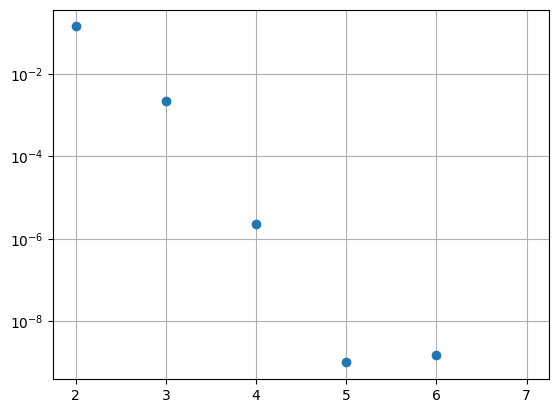

In [44]:
fig1, ax = plt.subplots(1, 1)
ax.plot(N_exc_list, [data_dict["efficiency_"+str(j)][-15] - data_dict["efficiency_"+str(7)][-15] for j in N_exc_list], 'o')
#ax.set_ylim(0.50589265, 0.50589269)
ax.set_yscale('log')
ax.grid(True)

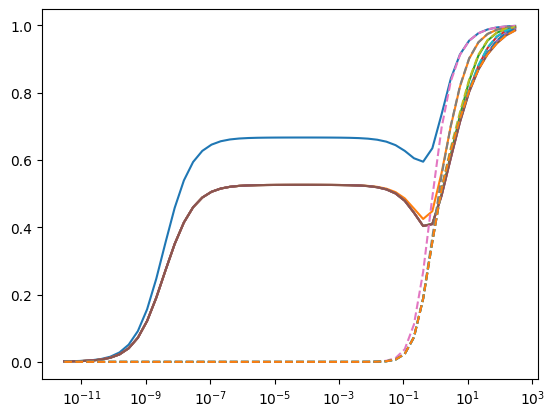

In [45]:
# transmissions
fig_tran, ax = plt.subplots(1, 1)
ax.plot(a_inc_list**2 / (5.1e8), np.array([data_dict['transmission_L_'+str(j)] for j in N_exc_list]).T)
ax.plot(a_inc_list**2 / (5.1e8), np.array([data_dict['transmission_R_'+str(j)] for j in N_exc_list]).T, '--')
ax.set_xscale('log')
# ax.set_xlim(0.1,3e2)
# ax.set_ylim(0.7,1)

(0.0, 0.01)

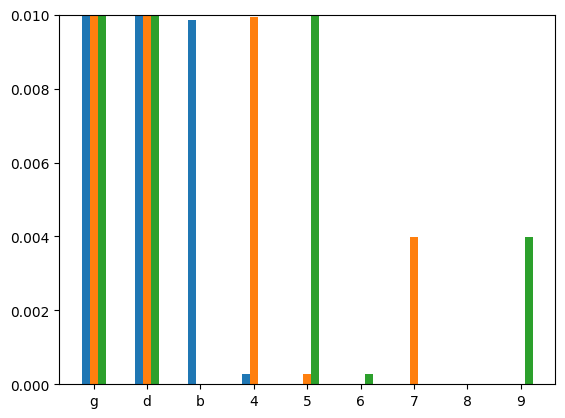

In [46]:
# bar graphs
fig_bar, ax = plt.subplots(1, 1)
width = 0.15
ax.bar(range(0, 4), np.real(np.diag(data_dict['rho_ss_DB_L_'+str(2)][-15])), width)
ax.bar(np.arange(0, 9) + width, np.real(np.diag(data_dict['rho_ss_DB_L_'+str(3)][-15])), width)
ax.bar(np.arange(0, 9) + 2*width, np.real(np.diag(data_dict['rho_ss_DB_L_'+str(4)][-15]))[:9], width)
# ax.bar(x + width, y2, width,
#         color=list(plt.rcParams['axes.prop_cycle'])[3]['color'])
ax.set_xticks(np.arange(0, 9) + width, labels=['g', 'd', 'b', '4', '5', '6','7', '8', '9'])
ax.set_ylim(0,0.01)

In [47]:
data_dict['rho_ss_DB_L_'+str(2)][-20][np.abs(data_dict['rho_ss_DB_L_'+str(2)][-20])>0.04]

array([0.33345703+0.j, 0.66617846+0.j])

In [17]:
data_dict['rho_ss_DB_L_'+str(2)][-20]

array([[ 3.33457028e-01+0.00000000e+00j,  2.67384160e-07-1.48129975e-03j,
        -1.10188327e-02-2.42756690e-06j, -3.63719354e-04-1.60188543e-07j],
       [ 2.67384160e-07+1.48129975e-03j,  6.66178461e-01+0.00000000e+00j,
        -4.13484312e-09-2.67595367e-08j, -3.31338567e-08-1.61927118e-06j],
       [-1.10188327e-02+2.42756690e-06j, -4.13484310e-09+2.67595367e-08j,
         3.64112961e-04+0.00000000e+00j,  1.20188437e-05+2.64789871e-09j],
       [-3.63719354e-04+1.60188543e-07j, -3.31338567e-08+1.61927118e-06j,
         1.20188437e-05-2.64789871e-09j,  3.97161852e-07+0.00000000e+00j]])

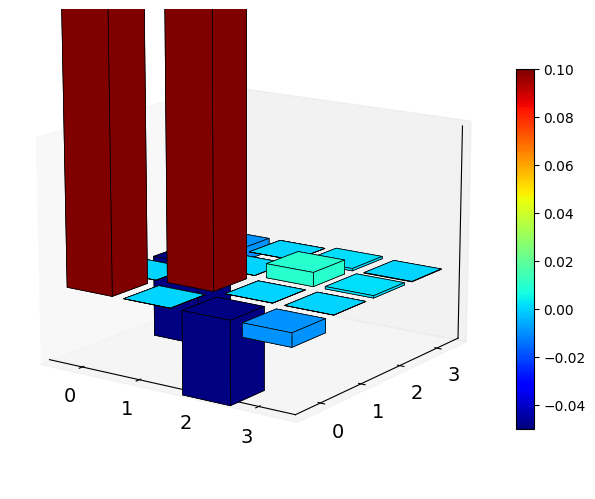

In [36]:
num = 2
fig_m, ax = qt.matrix_histogram(data_dict['rho_ss_DB_L_'+str(num)][-15], limits=[-0.05, 0.1],
                                options={'proj_type': 'persp'})
ax.view_init(azim=-55, elev=15)

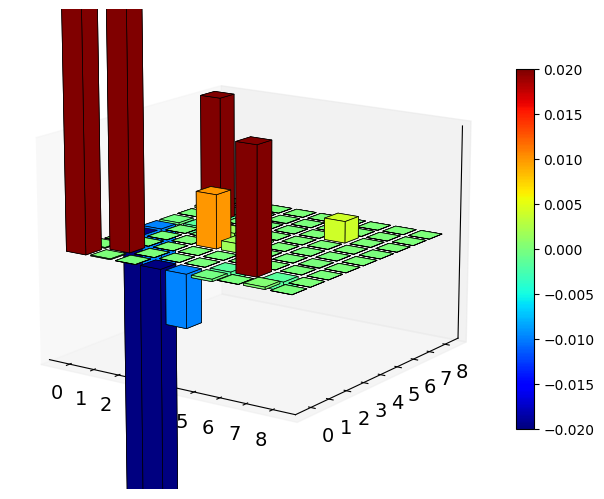

In [75]:
num = 3
fig_m, ax = qt.matrix_histogram(data_dict['rho_ss_DB_L_'+str(num)][-15], limits=[-0.02, 0.02],
                                options={'proj_type': 'persp'})
ax.view_init(azim=-55, elev=15)

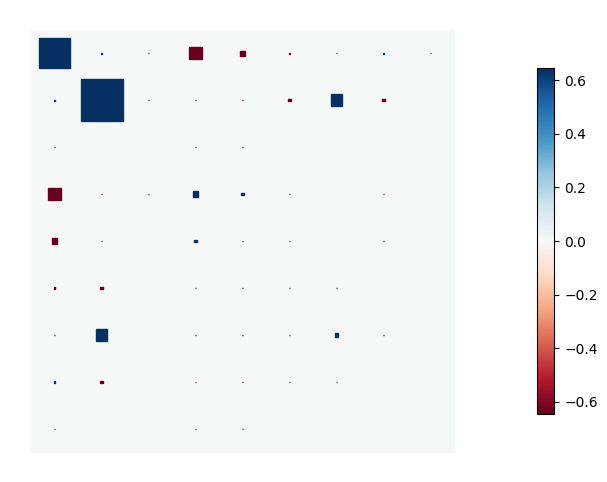

In [66]:
num = 3
import matplotlib as mpl
fig_m, ax = qt.hinton(data_dict['rho_ss_DB_L_'+str(num)][-15], color_style='threshold')#, cmap=mpl.colormaps['bwr'])